In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
from sets import Set
import calendar
import seaborn as sns
import csvWOD
import copy
import seawater as SW
from mpl_toolkits.basemap import Basemap

# switch to unbuffered output
class Unbuffered(object):
    def __init__(self, stream):
        self.stream = stream
    def write(self, data):
        self.stream.write(data)
        self.stream.flush()
    def __getattr__(self, attr):
        return getattr(self.stream, attr)

import sys
sys.stdout = Unbuffered(sys.stdout)

sns.set()
sns.set_style("darkgrid")
sns.set_context("poster")


%matplotlib inline

In [2]:
cast_inf = []

FILES = ['../../5_WOD13_Data/WOD13_004/ocldb1432579402.10924.CTD.csv',
         '../../5_WOD13_Data/WOD13_004/ocldb1432579402.10924.CTD2.csv',
         '../../5_WOD13_Data/WOD13_004/ocldb1432579402.10924.CTD3.csv',
         '../../5_WOD13_Data/WOD13_004/ocldb1432579402.10924.CTD4.csv',
         '../../5_WOD13_Data/WOD13_004/ocldb1432579402.10924.CTD5.csv'
         #'../../5_WOD13_Data/WOD13_004/ocldb1432579402.10924.OSD.csv'
        ]

for fn in FILES:
    print '-----------------------------------------------------------------'
    print fn
    print '-----------------------------------------------------------------'
    print '> Parsing'
    tmp_casts = []
    tmp_casts = csvWOD.csvWOD_readcasts(fn)
    print '> Done parsing'
    print '> Regionally filtering' # likely don't need this filter 
    tmp_casts = csvWOD.csvWOD_filter_region(tmp_casts,-160,-120,15,60)
    print '> Done filtering'
    print '> Appending new casts'
    cast_inf.extend(tmp_casts)
    print '> Done' 
    print ''
    
print 'Total casts: ', len(cast_inf)

-----------------------------------------------------------------
../../5_WOD13_Data/WOD13_004/ocldb1432579402.10924.CTD.csv
-----------------------------------------------------------------
> Parsing
> Done parsing
> Regionally filtering
> Done filtering
> Appending new casts
> Done

-----------------------------------------------------------------
../../5_WOD13_Data/WOD13_004/ocldb1432579402.10924.CTD2.csv
-----------------------------------------------------------------
> Parsing
> Done parsing
> Regionally filtering
> Done filtering
> Appending new casts
> Done

-----------------------------------------------------------------
../../5_WOD13_Data/WOD13_004/ocldb1432579402.10924.CTD3.csv
-----------------------------------------------------------------
> Parsing
> Done parsing
> Regionally filtering
> Done filtering
> Appending new casts
> Done

-----------------------------------------------------------------
../../5_WOD13_Data/WOD13_004/ocldb1432579402.10924.CTD4.csv
--------------

In [3]:
def get_EW_info(cast_inf,EPS=0.05):
    '''
    get_EW_info
    
    desc
    ----
    Loops through all casts in cast_inf and sorts into four categories:
    ALL   -- contains all casts
    EW_T  -- contains cast info matching temperature
    EW_S  -- contains cast info matching salinity
    EW_TS -- contains cast info matching TS data
    '''
    lats = []
    lons = []
    yrs = Set([])

    EW_T0 = 6.3
    EW_T0_eps = EPS
    EW_S0 = 33.9
    EW_S0_eps = EPS
    
    ALL = {'lats' : [], 'lons' : [], 'yrs' : Set([]), 'dpths' : []}
    EW_T = {'lats' : [], 'lons' : [], 'dpths' : []}
    EW_S = {'lats' : [], 'lons' : [], 'dpths' : []}
    EW_TS = {'lats' : [], 'lons' : [], 'dpths' : []}
    
    for cast in cast_inf:
        if 'Temperatur' in cast['Variables'] and 'Salinity' in cast['Variables'] and 'Depth' in cast:
            for ii in range(0,len(cast['Depth'])):
                ALL['lats'].append(cast['Latitude'])
                ALL['lons'].append(cast['Longitude'])    
                ALL['yrs'].add(cast['Year'])
                ALL['dpths'].append(cast['Depth'][ii])
                if cast['Temperatur'][ii] > EW_T0-EW_T0_eps and cast['Temperatur'][ii] < EW_T0+EW_T0_eps:
                    EW_T['lats'].append(cast['Latitude'])
                    EW_T['lons'].append(cast['Longitude'])
                    EW_T['dpths'].append(cast['Depth'][ii])
                if cast['Salinity'][ii] > EW_S0-EW_S0_eps and cast['Salinity'][ii] < EW_S0+EW_S0_eps:
                    EW_S['lats'].append(cast['Latitude'])
                    EW_S['lons'].append(cast['Longitude'])
                    EW_S['dpths'].append(cast['Depth'][ii])
                if cast['Temperatur'][ii] > EW_T0-EW_T0_eps and cast['Temperatur'][ii] < EW_T0+EW_T0_eps and \
                   cast['Salinity'][ii] > EW_S0-EW_S0_eps and cast['Salinity'][ii] < EW_S0+EW_S0_eps:
                    EW_TS['lats'].append(cast['Latitude'])
                    EW_TS['lons'].append(cast['Longitude'])
                    EW_TS['dpths'].append(cast['Depth'][ii])
    return (ALL,EW_T,EW_S,EW_TS)

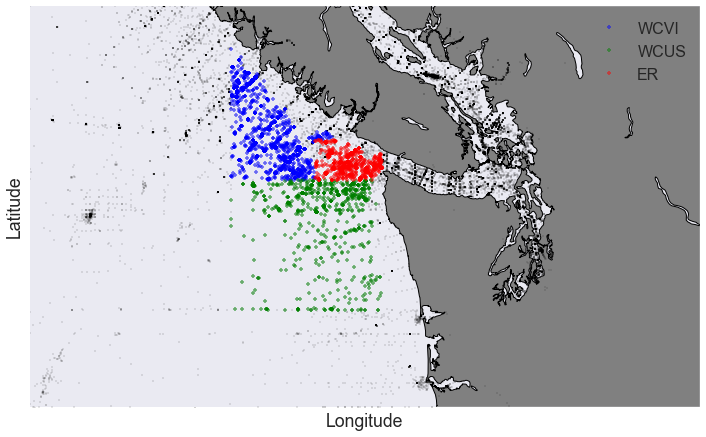

In [4]:
# move the centre down just a touch so region doesn't intersect with VI too much
MB07 = [-(125 + 19.49/60.0),48+28.2/60.0-0.1] 

ERdelx = 0.55
ERdely = 0.35
ER_x = [MB07[0]-ERdelx,MB07[0]+ERdelx,MB07[0]+ERdelx,MB07[0]-ERdelx,MB07[0]-ERdelx]
ER_y = [MB07[1]-ERdely,MB07[1]-ERdely,MB07[1]+ERdely,MB07[1]+ERdely,MB07[1]-ERdely]

ER_x = [-125.75,-124.75,-124.75,-125.75,-125.75]
ER_y = [48.3,48.3,48.7,48.7,48.3]

WCVI_lnmin = -127
WCVI_lnmax = -124.75
WCVI_ltmin =  48.3
WCVI_ltmax =  49.6

WCUS_lnmin = -127
WCUS_lnmax = -124.75
WCUS_ltmin =  47
WCUS_ltmax =  48.3

WCVI_cinf = []
WCUS_cinf = []
ER_cinf = []

WCVI_slope = float(WCVI_ltmin-WCVI_ltmax)/float(WCVI_lnmax-WCVI_lnmin)
WCVI_int   = WCVI_ltmax - WCVI_slope*WCVI_lnmin #y - mx

for cast in cast_inf:
    lt = cast['Latitude']
    ln = cast['Longitude']
    
    # only keep casts with depth info
    if 'Depth' not in cast:
        continue
        
    # only keep deep casts that include points in the range of interest
    if max(cast['Depth']) < 90:
        continue
    
    # ER
    if ln >= min(ER_x) and ln <= max(ER_x) and lt >= min(ER_y) and lt <= max(ER_y):
        ER_cinf.append(cast)
    # WCUS
    elif ln >= WCUS_lnmin and ln <= WCUS_lnmax and lt >= WCUS_ltmin and lt <= WCUS_ltmax:
        WCUS_cinf.append(cast)
    # WCVI
    elif ln >= WCVI_lnmin and  ln <= WCVI_lnmax and \
       lt >= WCVI_ltmin and lt <= WCVI_slope*ln + WCVI_int:
        WCVI_cinf.append(cast)
    
        
ER_lon = [k['Longitude'] for k in ER_cinf]
ER_lat = [k['Latitude'] for k in ER_cinf]

WCVI_lon = [k['Longitude'] for k in WCVI_cinf]
WCVI_lat = [k['Latitude'] for k in WCVI_cinf]

WCUS_lon = [k['Longitude'] for k in WCUS_cinf]
WCUS_lat = [k['Latitude'] for k in WCUS_cinf]

plt.figure(figsize=(12,12))

sns.set_style("darkgrid")
sns.set_context("poster")

b_map = Basemap(projection='merc',llcrnrlat=46,urcrnrlat=50,\
            llcrnrlon=-130,urcrnrlon=-120,lat_ts=20,resolution='h')

#plt.plot(all_filt['ALL']['lons'],all_filt['ALL']['lats'],'.k',ms=2,alpha=0.1)

x_all, y_all = b_map([k['Longitude'] for k in cast_inf],[k['Latitude'] for k in cast_inf])
b_map.plot(x_all,y_all,'.k',ms=2,alpha=0.5)

x_WCVI, y_WCVI = b_map(WCVI_lon,WCVI_lat)
b_map.plot(x_WCVI,y_WCVI,'.b',ms=8,label='WCVI',alpha=.5)

x_WCUS, y_WCUS = b_map(WCUS_lon,WCUS_lat)
b_map.plot(x_WCUS,y_WCUS,'.g',ms=8,label='WCUS',alpha=.5)

x_ER, y_ER = b_map(ER_lon,ER_lat)
b_map.plot(x_ER,y_ER,'.r',ms=8,label='ER',alpha=.5)

b_map.drawcoastlines()
b_map.fillcontinents(color=[0.5,0.5,0.5],lake_color=None)
#plt.ylim((46,50))
#plt.xlim((-130,-120))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [5]:
mnthER_filt = [[] for k in range(1,13)]
mnthWCVI_filt = [[] for k in range(1,13)]
mnthWCUS_filt = [[] for k in range(1,13)]

MIN_YEAR = 1960
MAX_YEAR = 2015

# look at monthly values/percentages/stats for each month
for ii in range(1,13):
    ALL,EW_T,EW_S,EW_TS = get_EW_info(csvWOD.csvWOD_filter_month(csvWOD.csvWOD_filter_year(ER_cinf,MIN_YEAR,MAX_YEAR),ii),EPS=0.05)
    mnthER_filt[ii-1] = copy.copy(EW_TS)
    mnthER_filt[ii-1]['count'] = len(ALL['lats'])
    if len(ALL['lats']) > 0:
        mnthER_filt[ii-1]['match_perc'] = float(len(EW_TS['lats']))/float(len(ALL['lats']))
    else:
        mnthER_filt[ii-1]['match_perc'] = np.nan
    
    ALL,EW_T,EW_S,EW_TS = get_EW_info(csvWOD.csvWOD_filter_month(csvWOD.csvWOD_filter_year(WCVI_cinf,MIN_YEAR,MAX_YEAR),ii),EPS=0.05)
    mnthWCVI_filt[ii-1] = copy.copy(EW_TS)
    mnthWCVI_filt[ii-1]['count'] = len(ALL['lats'])
    if len(ALL['lats']) > 0:
        mnthWCVI_filt[ii-1]['match_perc'] = float(len(EW_TS['lats']))/float(len(ALL['lats']))
    else:
        mnthWCVI_filt[ii-1]['match_perc'] = np.nan        

    ALL,EW_T,EW_S,EW_TS = get_EW_info(csvWOD.csvWOD_filter_month(csvWOD.csvWOD_filter_year(WCUS_cinf,MIN_YEAR,MAX_YEAR),ii),EPS=0.05)
    mnthWCUS_filt[ii-1] = copy.copy(EW_TS)
    mnthWCUS_filt[ii-1]['count'] = len(ALL['lats'])
    if len(ALL['lats']) > 0:
        mnthWCUS_filt[ii-1]['match_perc'] = float(len(EW_TS['lats']))/float(len(ALL['lats']))
    else:
        mnthWCUS_filt[ii-1]['match_perc'] = np.nan        

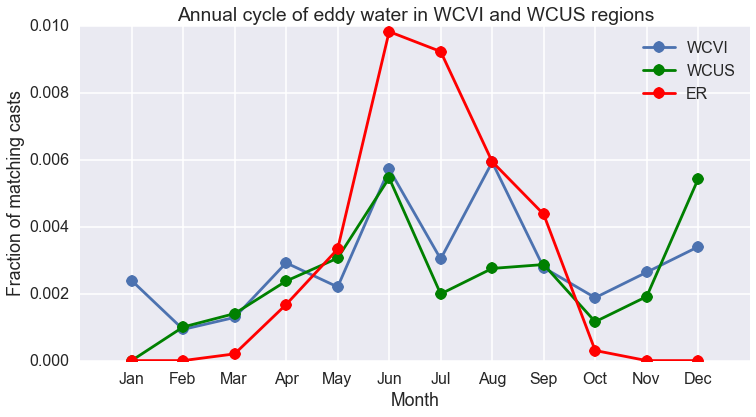

Correlation coefficients for mean EW freq
Corr(WCUS,WCVI)[Jan-Dec] :  0.633651821516
Corr(ER,  WCVI)[Mar-Sep] :  0.684448244811
Corr(ER,  WCUS)[Mar-Sep] :  0.606625432187


In [6]:
plt.figure(figsize=(12,6))

#plt.bar(np.arange(1,13)-0.2, [k['match_perc'] for k in mnthWCVI_filt], label='WCVI',alpha=0.8,width=0.4)
#plt.bar(np.arange(1,13)-0.4, [k['match_perc'] for k in mnthWCUS_filt], label='WCUS',color='g',alpha=0.8,width=0.4)
#plt.bar(np.arange(1,13)-0.6, [k['match_perc'] for k in mnthER_filt], label='ER',alpha=0.8,color='r',width=0.4)

plt.plot(np.arange(1,13), [k['match_perc'] for k in mnthWCVI_filt],'-o', label='WCVI')
plt.plot(np.arange(1,13), [k['match_perc'] for k in mnthWCUS_filt],'-o', label='WCUS',color='g')
plt.plot(np.arange(1,13),   [k['match_perc'] for k in mnthER_filt],'-o', label='ER',color='r')

plt.xlim((0,13))
#|plt.ylim((0,.007))

plt.xticks(np.arange(1,13),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.legend()

plt.xlabel('Month')
plt.ylabel('Fraction of matching casts')
plt.title('Annual cycle of eddy water in WCVI and WCUS regions')
plt.show()


## ALSO LOOK AT THE CORRELATION BETWEEN CURVES
WCVI_freq = [k['match_perc'] for k in mnthWCVI_filt] 
WCUS_freq = [k['match_perc'] for k in mnthWCUS_filt]
ER_freq = [k['match_perc'] for k in mnthER_filt]

print "Correlation coefficients for mean EW freq"
print "==========================================="
print "Corr(WCUS,WCVI)[Jan-Dec] : ", np.corrcoef(WCUS_freq,WCVI_freq)[1,0]
print "Corr(ER,  WCVI)[Mar-Sep] : ", np.corrcoef(ER_freq[2:9],WCVI_freq[2:9])[1,0]
print "Corr(ER,  WCUS)[Mar-Sep] : ", np.corrcoef(ER_freq[2:9],WCUS_freq[2:9])[1,0]

/home/rirwin/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


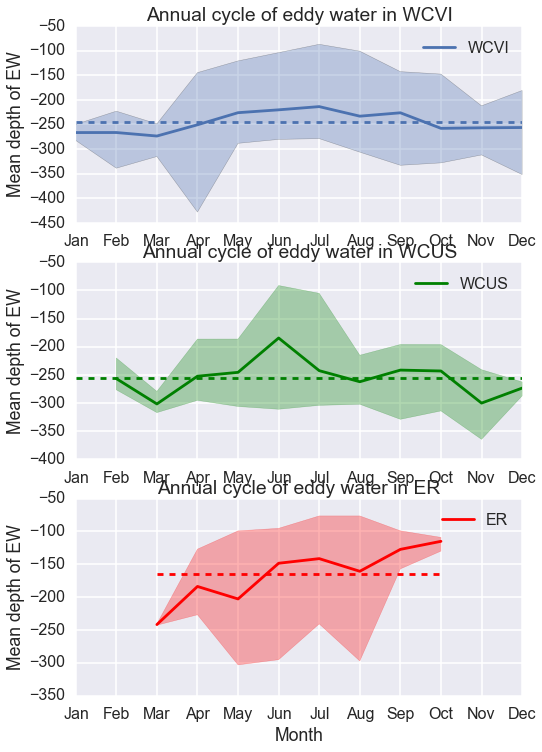

In [7]:
plt.figure(figsize=(8,12))

meanWCVI = np.nanmean([-np.mean(k['dpths']) for k in mnthWCVI_filt])
meanWCUS = np.nanmean([-np.mean(k['dpths']) for k in mnthWCUS_filt])
meanER = np.nanmean([-np.mean(k['dpths']) for k in mnthER_filt])
stdWCVI = np.nanstd([-np.mean(k['dpths']) for k in mnthWCVI_filt])
stdWCUS = np.nanstd([-np.mean(k['dpths']) for k in mnthWCUS_filt])
stdER = np.nanstd([-np.mean(k['dpths']) for k in mnthER_filt])

plt.subplot(3,1,1)
plt.plot(np.arange(1,13), [-np.mean(k['dpths']) for k in mnthWCVI_filt], label='WCVI')
plt.gca().set_color_cycle(None)
#plt.fill_between(np.arange(1,13),[-np.mean(k['dpths']) for k in mnthWCVI_filt]-stdWCVI,[-np.mean(k['dpths']) for k in mnthWCVI_filt]+stdWCVI,alpha=0.3)
plt.fill_between(np.arange(1,13),[-np.min(k['dpths']) for k in mnthWCVI_filt],[-np.max(k['dpths']) for k in mnthWCVI_filt],alpha=0.3)
plt.gca().set_color_cycle(None)
plt.plot(np.arange(1,13), [meanWCVI for k in range(1,13)],'--')
plt.xlim((1,12))
plt.xticks(np.arange(1,13),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.legend()

plt.ylabel('Mean depth of EW')
plt.title('Annual cycle of eddy water in WCVI')

plt.subplot(3,1,2)
plt.plot(np.arange(1,13), [-np.mean(k['dpths']) for k in mnthWCUS_filt], label='WCUS',color='g')
#plt.fill_between(np.arange(1,13),[-np.mean(k['dpths']) for k in mnthWCUS_filt]-stdWCUS,[-np.mean(k['dpths']) for k in mnthWCUS_filt]+stdWCUS,color='g',alpha=0.3)
plt.fill_between(np.arange(2,13),[-np.nanmin(k['dpths']) for k in mnthWCUS_filt[1:12]],[-np.nanmax(k['dpths']) for k in mnthWCUS_filt[1:12]],color='g',alpha=0.3)
plt.plot(np.arange(1,13), [meanWCUS for k in range(1,13)],'--g')

plt.xlim((1,12))
plt.xticks(np.arange(1,13),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.legend()

plt.ylabel('Mean depth of EW')
plt.title('Annual cycle of eddy water in WCUS')

plt.subplot(3,1,3)
plt.plot(np.arange(1,13), [-np.mean(k['dpths']) for k in mnthER_filt], label='ER',color='r')
#plt.fill_between(np.arange(1,13),[-np.mean(k['dpths']) for k in mnthER_filt]-stdER,[-np.mean(k['dpths']) for k in mnthER_filt]+stdER,color='r',alpha=0.3)
plt.fill_between(np.arange(3,11),[-np.nanmin(k['dpths']) for k in mnthER_filt[2:10]],[-np.nanmax(k['dpths']) for k in mnthER_filt[2:10]],color='r',alpha=0.3)
plt.plot(np.arange(3,11), [meanER for k in range(2,10)],'--r')

plt.xlim((1,12))
plt.xticks(np.arange(1,13),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.legend()

plt.xlabel('Month')
plt.ylabel('Mean depth of EW')
plt.title('Annual cycle of eddy water in ER')
plt.show()


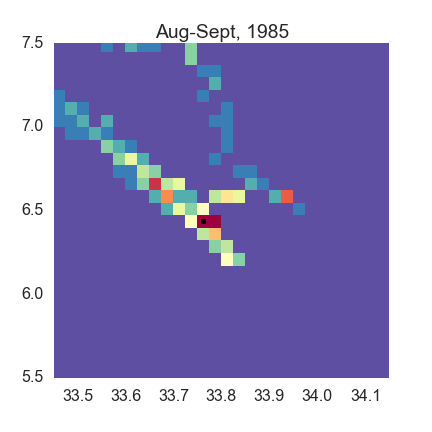
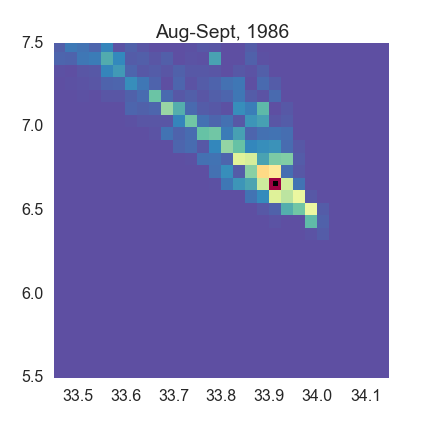
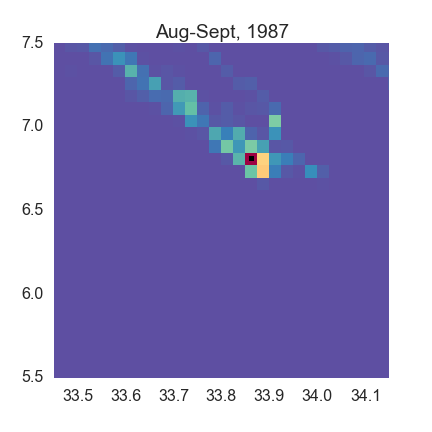
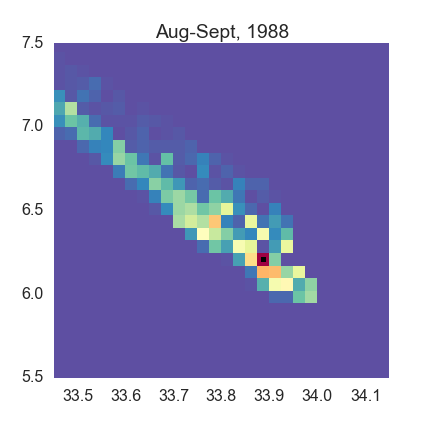
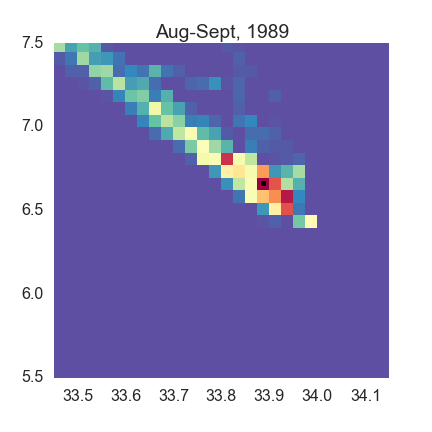
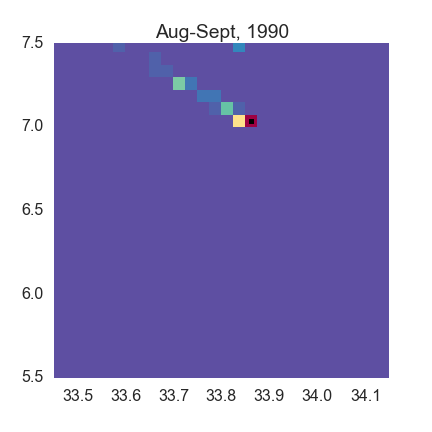
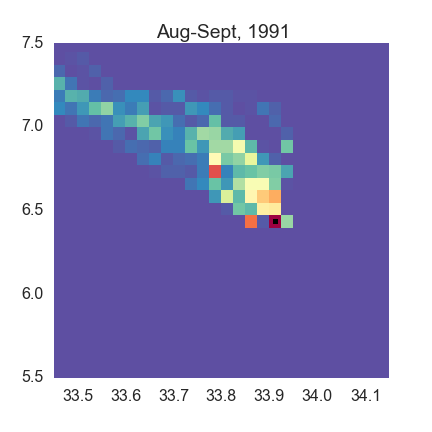
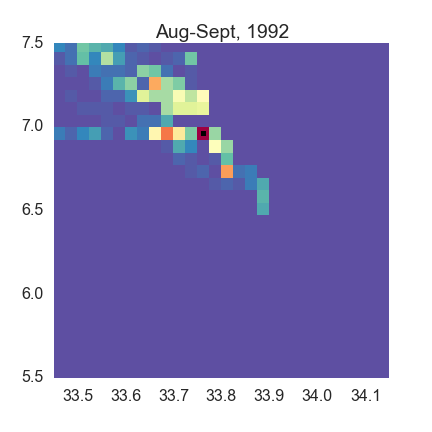
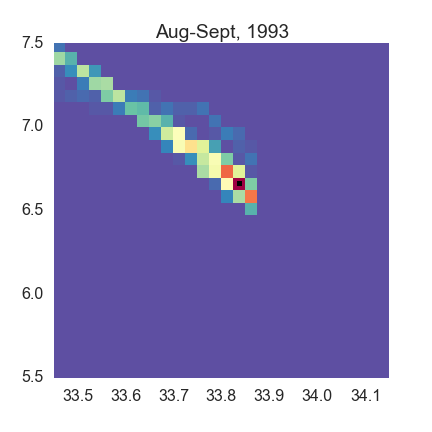
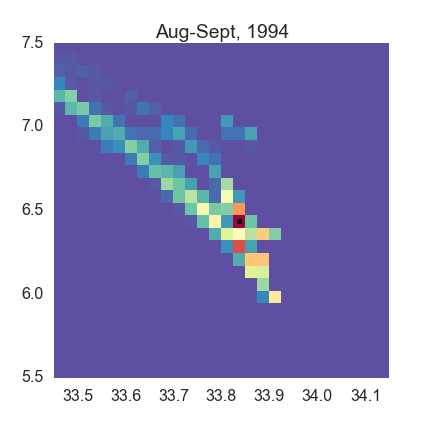
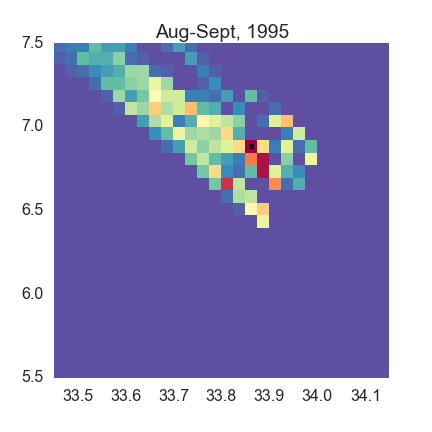
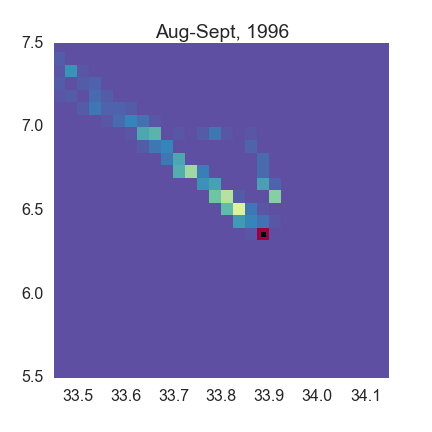
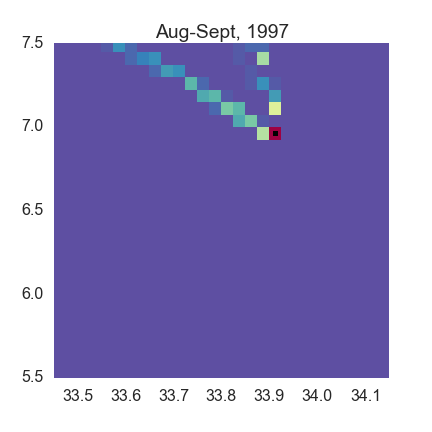
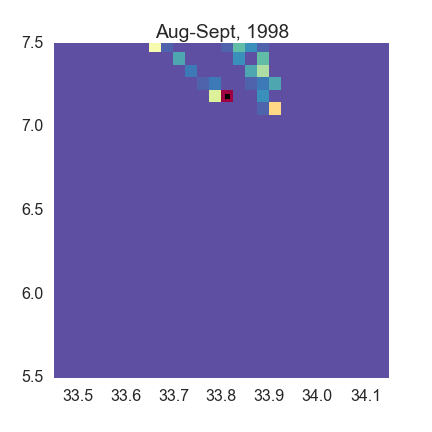
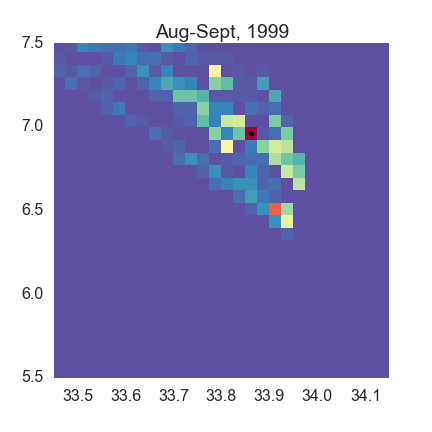
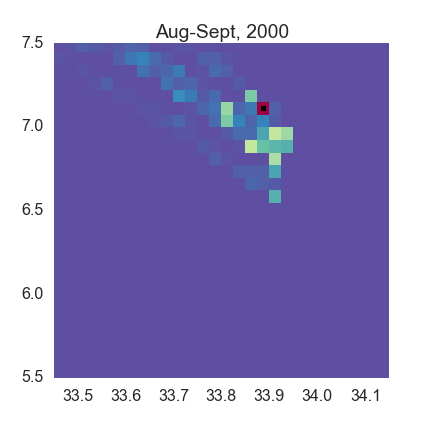
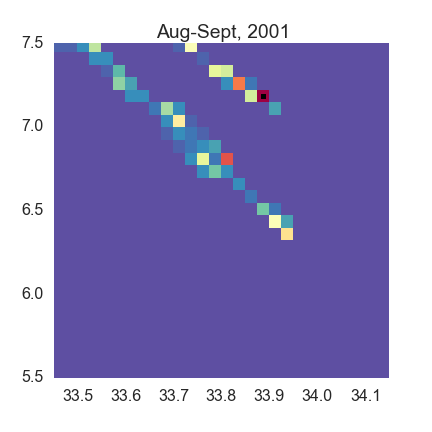
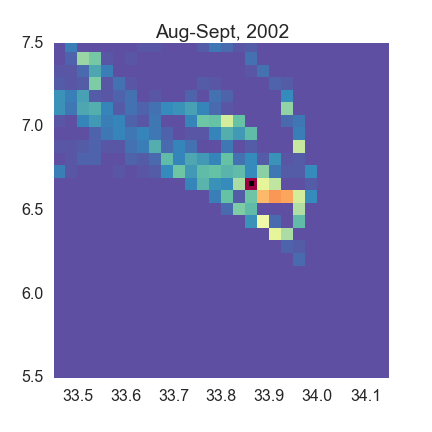
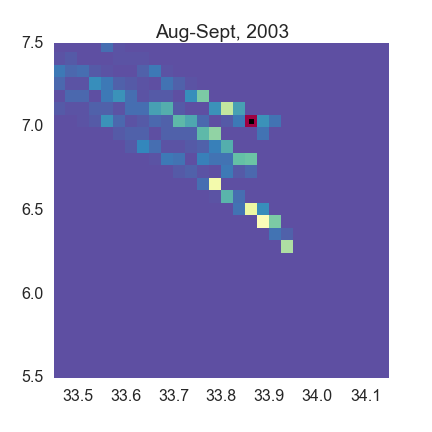
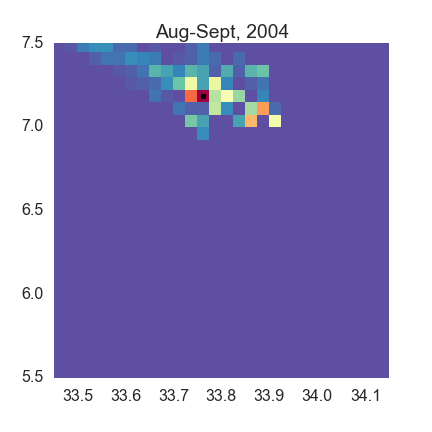
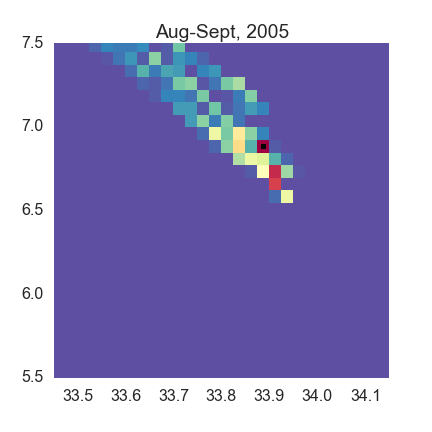

In [8]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure(figsize=(6,6))
ax = plt.axes(xlim=(30,35), ylim=(2,18))
line, = ax.plot([], [], lw=2)

# TAKE IN ER REGION FOR MAY-AUG DATA
#ER_cast_inf = csvWOD.csvWOD_filter_month(csvWOD.csvWOD_filter_region(cast_inf,min(ER_x),max(ER_x),min(ER_y),max(ER_y)),5,8)

# TAKE IN ER REGION FOR AUG-SEP DATA
ER_cast_inf = csvWOD.csvWOD_filter_month(csvWOD.csvWOD_filter_region(cast_inf,min(ER_x),max(ER_x),min(ER_y),max(ER_y)),8,9)

MIN_YEAR = 1985
MAX_YEAR = 2005
yrER_cast_inf = [[] for k in range(MIN_YEAR,MAX_YEAR+1)]

# SORT INTO YEARS
for ii in range(MIN_YEAR,MAX_YEAR+1):
    for jj in ER_cast_inf:
        # only keep casts that contain T-S data, and are of the appropriate year
        # additionally, only keep casts that have a vertical profile and have a correct
        # depth range. for casts that are too deep, may be focussing on larger water masses
        # for casts that are too shallow, they won't contain any EW data, and will bias the
        # clusters to shallower water data.
        if jj['Year'] == ii and 'Salinity' in jj and 'Temperatur' in jj \
          and len(jj['Depth']) > 1 and max(jj['Depth']) > 90 and max(jj['Depth']) < 350:
            yrER_cast_inf[ii-MIN_YEAR].append(jj)

yearER_T = [[] for k in range(MIN_YEAR,MAX_YEAR+1)]
yearER_S = [[] for k in range(MIN_YEAR,MAX_YEAR+1)]
for ii in range(MIN_YEAR,MAX_YEAR+1):
    # append all lists of lists
    tmp_lst = [k['Temperatur'] for k in yrER_cast_inf[ii-MIN_YEAR]]
    # extend each list -- rearrange so it's 1D instead of 2D list-of-lists
    yearER_T[ii-MIN_YEAR] = [x for sublist in tmp_lst for x in sublist]

    # do the same thing for salinity
    tmp_lst = [k['Salinity'] for k in yrER_cast_inf[ii-MIN_YEAR]]
    yearER_S[ii-MIN_YEAR] = [x for sublist in tmp_lst for x in sublist]

# setup the temperature and salinity bins
Tbins = np.arange(4,16.1,0.075)
# salinity bins have a smaller delta between bin edges
Sbins = np.arange(33,35.1,0.025)

# Ty and Sx contain the x&y point info for T&S
Ty = (Tbins[0:-1]+Tbins[1:])/2
Sx = (Sbins[0:-1]+Sbins[1:])/2

# setup empty lists
histTS = []
yrEW_T = []
yrEW_S = []

# create the histograms, and save the cell with the highest count
for ii in range(MIN_YEAR,MAX_YEAR+1):
    hist_tmp = np.histogram2d(yearER_S[ii-MIN_YEAR],yearER_T[ii-MIN_YEAR],bins=[Sbins,Tbins])[0]
    IND = np.unravel_index(hist_tmp.argmax(), hist_tmp.shape)
    # make sure the cell is significant -- if there are fewer than 3 data points, then
    # it's probably not significant
    if hist_tmp[IND[0],IND[1]] > 3:
        yrEW_S.append(Sx[IND[-2]])
        yrEW_T.append(Ty[IND[-1]])
    # don't count anything that's insignificant
    else:
        yrEW_S.append(np.nan)
        yrEW_T.append(np.nan)
    # append the histogram to the full list of histogram data -- used for pcolor plotting
    histTS.append(hist_tmp)

    
### Setup the animation
def init():
    # not really necessary
    line.set_data([], [])
    return line,

# this is where are the plotting work is done
def animate(i):
    # clear the axis for blit plotting
    ax.cla()
    
    # plot all individual cast data as a transparent point
    #ax.plot(yearER_S[i],yearER_T[i],'.k',ms=3,alpha=0.05)
    
    # pcolor the histogram data
    ax.pcolor(Sbins[:-1],Tbins[:-1],histTS[i].transpose(),cmap='Spectral_r')
    
    # overlay the point that contains most data -- the clustered bin
    # this is the eddy water definition for year MIN_YEAR+i
    ax.plot(yrEW_S[i],yrEW_T[i],'sk',ms=5)
    
    # set the title and axes limits
    ax.set_title('Aug-Sept, '+ str(MIN_YEAR+i))
    ax.set_xlim((33.45,34.15))
    ax.set_ylim((5.5,7.5))
    
    return line,

# create the animation
animation.FuncAnimation(fig, animate, init_func=init,frames=len(yrER_cast_inf),interval=500)

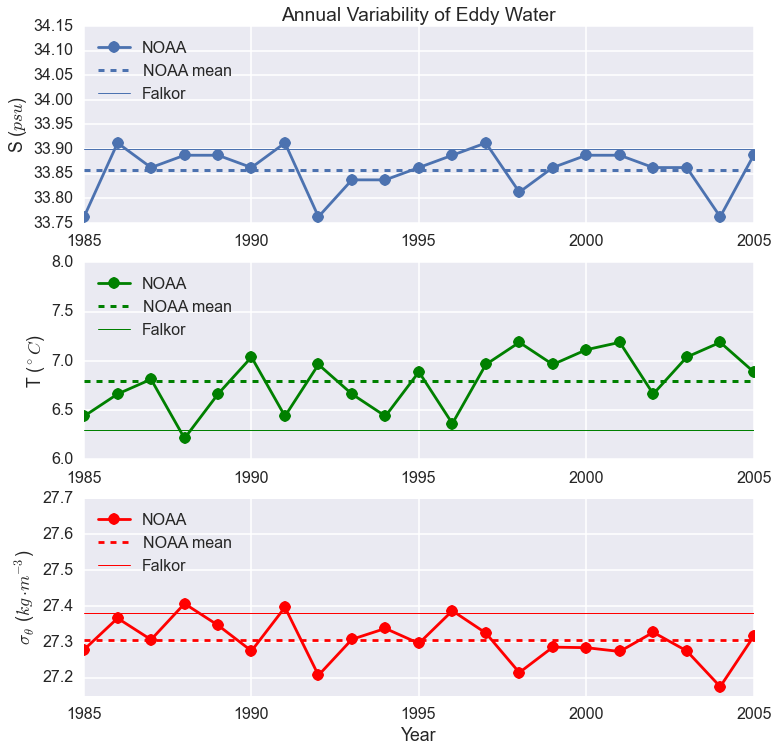

In [23]:
plt.figure(figsize=(12,12))

plt.subplot(3,1,1)
# plot the NOAA annual data
plt.plot(np.arange(MIN_YEAR,MAX_YEAR+1),yrEW_S,'-o',label='NOAA')
plt.gca().set_color_cycle(None)
plt.plot(np.arange(MIN_YEAR,MAX_YEAR+1),[np.nanmean(yrEW_S) for k in range(MIN_YEAR,MAX_YEAR+1)],'--',lw=3,label='NOAA mean')

# plot the Falkor13 data as a horizontal line
plt.gca().set_color_cycle(None)
plt.plot([MIN_YEAR,MAX_YEAR],[33.9,33.9],'-',lw=1,label='Falkor')

# setup axis title and limits
plt.ylim((33.75,34.15))
plt.xlim((MIN_YEAR,MAX_YEAR))
#plt.title('Salinity of EW')
plt.ylabel(r'S ($psu$)')
plt.legend(loc=2)
plt.title('Annual Variability of Eddy Water')

plt.subplot(3,1,2)
# plot the NOAA annual temp data
plt.plot(np.arange(MIN_YEAR,MAX_YEAR+1),yrEW_T,'-og',label='NOAA')
plt.plot(np.arange(MIN_YEAR,MAX_YEAR+1),[np.nanmean(yrEW_T) for k in range(MIN_YEAR,MAX_YEAR+1)],'--g',lw=3,label='NOAA mean')

# plot the Falkor13 data
plt.plot([MIN_YEAR,MAX_YEAR],[6.3,6.3],'-g',lw=1,label='Falkor')

# setup axis title and limits
plt.ylim((6,8))
plt.xlim((MIN_YEAR,MAX_YEAR))
#plt.title('Temperature of EW')
plt.ylabel(r'T ($^\circ C$)')
plt.legend(loc=2)

sigmaT_EW = []
for ii in range(0,MAX_YEAR-MIN_YEAR+1):
    sigmaT_EW.append(SW.dens(yrEW_S[ii],yrEW_T[ii],-meanER)-1000)

falk_sigmaT = SW.dens(33.9,6.3,160)-1000
    
plt.subplot(3,1,3)    
plt.plot(np.arange(MIN_YEAR,MAX_YEAR+1),sigmaT_EW,'-or',label='NOAA')
plt.plot([MIN_YEAR,MAX_YEAR],[np.mean(sigmaT_EW),np.mean(sigmaT_EW)],'--r',label='NOAA mean')
plt.plot([MIN_YEAR,MAX_YEAR],[falk_sigmaT,falk_sigmaT],'-r',lw=1,label='Falkor')
plt.xlim((MIN_YEAR,MAX_YEAR))
plt.ylim((27.15,27.7))

plt.xlabel('Year')
plt.ylabel(r'$\sigma_\theta$ ($kg \cdot m^{-3}$)')
plt.legend(loc=2)
#plt.title('Eddy water pot. dens. anomaly')

plt.show()

In [10]:
print 'Corr. coeff. between EW T and EW S: ', np.corrcoef(yrEW_T,yrEW_S)[1,0]

Corr. coeff. between EW T and EW S:  -0.185847114877


Let's try to define a sigma level for this water. Look at the potential density anomaly year to year then calculate the mean. If there is not much variation around the mean sigma level, we can say that typically JdF eddy water is $\sigma_\theta=$...

In [19]:
print meanER

-165.115477097


In [1]:
tmp ='      132 321 412  4   421 4     4 '
print tmp
print tmp.split()


      132 321 412  4   421 4     4 
['132', '321', '412', '4', '421', '4', '4']
